In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Step 0: Setting Up

### Loading Libraries

In [2]:
# Installing the Huggingface's Transformers library
!pip install transformers

In [55]:
!pip install datasets

     |████████████████████████████████| 192 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 3.8 MB/s eta 0:00:011
     |████████████████████████████████| 243 kB 6.6 MB/s eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.56.2
    Uninstalling tqdm-4.56.2:
      Successfully uninstalled tqdm-4.56.2


In [62]:
# IMPORT LIBRARIES

# Utils
import os                                       # Operating system operations
import json                                     # Working with json file
import re                                       # Regular expression
import unicodedata                              # Unicode + regular expression
import random                                   # Random
import collections                              # Counter

# Computation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLP
import nltk
import gensim
import gensim.downloader as gensim_api

# Transformers
import transformers
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Datasets
from datasets import load_dataset

# ML utils
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, naive_bayes, pipeline, manifold, preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

# PyTorch
import torch

# Others
from lime import lime_text

### Loading Data

In [4]:
dirname = '/kaggle/input/nlp-getting-started'

train = pd.read_csv(os.path.join(dirname, 'train.csv'))
test = pd.read_csv(os.path.join(dirname, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(dirname, 'sample_submission.csv'))

In [5]:
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train.shape

(7613, 5)

In [6]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Initial observations:

* Training set includes 7,613 tweets
* 43% of the training set contains disaster tweets (signal)

In [7]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


#### Utils Functions

In [42]:
def compute_metrics(pred):
    """
    This function computes metrics for Transformers' fine tuning
    
    Args:
        pred: predictions from Transformers' Trainer
    
    Returns:
        A dictionary that contains metrics of interest for binary classification:
            (1) Accuracy
            (2) Precision
            (3) Recall
            (4) F1 Score
            (5) AUC
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall, "auc": auc}

In [61]:
def tokenize(batch):
    """
    Tokenize by batches for Transformers
    """
    return tokenizer(batch["text"], padding=True, truncation=True)

In [15]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [65]:
def set_cuda_seed(seed_val=42):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

## Step 1: EAD and Data Processing

In [16]:
all_train_texts = train.text.to_list()
all_train_labels = train.target.to_list()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    all_train_texts, all_train_labels, 
    test_size=0.2, 
    random_state=42
)

In [22]:
# Let's see the distribution of labels in training and val set
# They are pretty evenly distributed among two sets

print(collections.Counter(train_labels))
print(collections.Counter(val_labels))

Counter({0: 3468, 1: 2622})
Counter({0: 874, 1: 649})


#### Text Preprocessing

In [23]:
def preprocess_text(text, 
                    flg_stemm=False, 
                    flg_lemm=True, 
                    lst_stopwords=None):
    
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
                            
    ## back to string from list
    text = " ".join(lst_text)
    return text

lst_stopwords = nltk.corpus.stopwords.words("english")

contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    " u ": " you ",
    " ur ": " your ",
    " n ": " and ",
    "won't": "would not",
    'dis': 'this',
    'bak': 'back',
    'brng': 'bring'
}

def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x
    
def remove_emails(x):
     return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)


def remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def remove_rt(x):
    return re.sub(r'\brt\b', '', x).strip()

def remove_special_chars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x


def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

In [24]:
train['text_clean'] = train['text'].apply(lambda x: cont_to_exp(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_emails(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_urls(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_rt(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_special_chars(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_accented_chars(x))

In [25]:
train["text_clean"] = train["text_clean"].apply(lambda x: 
                                                preprocess_text(x, 
                                                                flg_stemm=True, 
                                                                flg_lemm=False,
                                                                lst_stopwords=lst_stopwords))

In [26]:
train.head(10)

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfir updat california hwi 20 close direct ...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood thisast heavi rain caus flash flood stre...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,im top hill see fire wood
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,there emerg evacu happen build across street
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,im afraid tornado come area


In [27]:
train_texts_processed = [cont_to_exp(text) for text in train_texts]
train_texts_processed = [remove_emails(text) for text in train_texts_processed]
train_texts_processed = [remove_urls(text) for text in train_texts_processed]
train_texts_processed = [remove_rt(text) for text in train_texts_processed]
train_texts_processed = [remove_special_chars(text) for text in train_texts_processed]
train_texts_processed = [remove_accented_chars(text) for text in train_texts_processed]
train_texts_processed = [preprocess_text(text,
                                         flg_stemm=True, 
                                         flg_lemm=False,
                                         lst_stopwords=lst_stopwords) for text in train_texts_processed]

In [28]:
train_texts_processed[:10]

['courag honest analysi need use atom bomb 1945 hiroshima70 japanes militari refus surrend',
 'zachzaidman 670thescor wld b shame golf cart becam engulf flame boycottbear',
 'tell barackobama rescind medal honor given us soldier massacr wound knee sign amp rt',
 'worri ca drought might affect extrem weather dampen economi',
 'youngheroesid lava blast amp power red pantherattack jamilazzaini alifaditha',
 'wreckag conclus confirm mh370 malaysia pm investig famili',
 'builder dental emerg ruin plan emot blackmail afternoon bump',
 'bmx issu areal flood advisori shelbi al till aug 5 900 pm cdt',
 '360wisenew china stock market crash gem rubbl',
 'robertoneill31 get hit foul ball sit hardli freak accid war zone']

In [29]:
val_texts_processed = [cont_to_exp(text) for text in val_texts]
val_texts_processed = [remove_emails(text) for text in val_texts_processed]
val_texts_processed = [remove_urls(text) for text in val_texts_processed]
val_texts_processed = [remove_rt(text) for text in val_texts_processed]
val_texts_processed = [remove_special_chars(text) for text in val_texts_processed]
val_texts_processed = [remove_accented_chars(text) for text in val_texts_processed]
val_texts_processed = [preprocess_text(text,
                                       flg_stemm=True, 
                                       flg_lemm=False,
                                       lst_stopwords=lst_stopwords) for text in val_texts_processed]

#### EDA

I'm also interested in the common features of a text-based dataset such as:

1. Word counts -- this is especially important because the BERT and related models can only take ~ 512 tokens per document.
2. Simple character count
3. Hashtag count
4. Mention count

In [30]:
def wordcount(x):
    length = len(str(x).split())
    return length

def charcount(x):
    s = x.split()
    x = ''.join(s)
    return len(x)

def hashtagcount(x):
    l = len([t for t in x.split() if t.startswith('#')])
    return l

def mentionscount(x):
    l = len([t for t in x.split() if t.startswith('@')])
    return l

In [31]:
char_count = [charcount(text) for text in train_texts]
word_count = [wordcount(text) for text in train_texts]
hashtag_count = [hashtagcount(text) for text in train_texts]
mention_count = [mentionscount(text) for text in train_texts]
text_len = [len(text) for text in train_texts]

#### Distribution of features such as character count, word count, hashtag count, mention count, length, stratified by target

In [32]:
train['char_count'] = train['text'].apply(lambda x: charcount(x))
train['word_count'] = train['text'].apply(lambda x: wordcount(x))
train['hashtag_count'] = train['text'].apply(lambda x: hashtagcount(x))
train['mention_count'] = train['text'].apply(lambda x: mentionscount(x))
train['length'] = train['text'].apply(len)

test['char_count'] = test['text'].apply(lambda x: charcount(x))
test['word_count'] = test['text'].apply(lambda x: wordcount(x))
test['hashtag_count'] = test['text'].apply(lambda x: hashtagcount(x))
test['mention_count'] = test['text'].apply(lambda x: mentionscount(x))
test['length'] = test['text'].apply(len)

<Figure size 576x720 with 0 Axes>

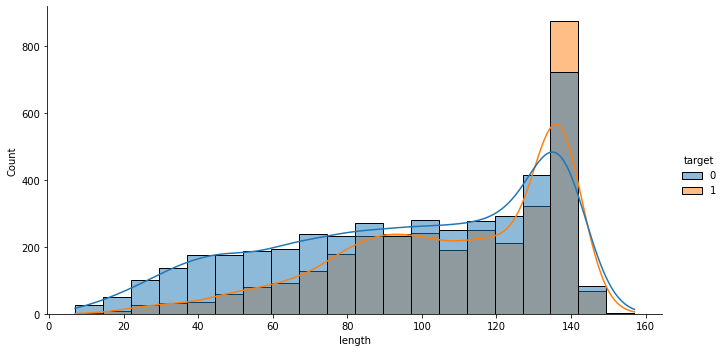

In [33]:
# Preliminary finding: the tweets that are classified as disaster tweets
# are usually longer.

plt.figure(figsize = (8, 10))
sns.displot(data=train,
            x='length', 
            hue='target', 
            kde=True,
            bins=20, 
            height=5, 
            aspect=1.9)

<Figure size 576x720 with 0 Axes>

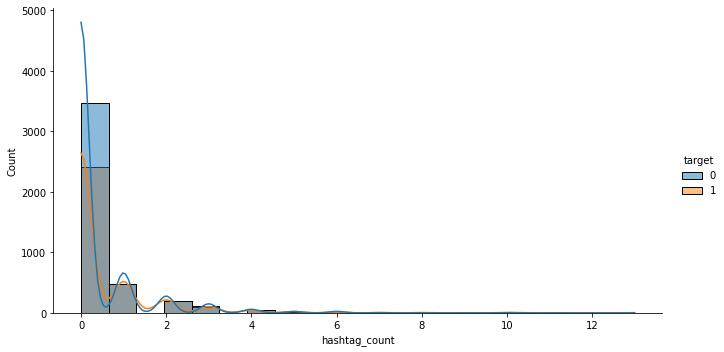

In [36]:
plt.figure(figsize = (8, 10))
sns.displot(data=train,
            kind='hist', 
            x='hashtag_count', 
            hue='target', 
            kde=True,
            bins=20,
            height=5, 
            aspect=1.9)

<Figure size 576x720 with 0 Axes>

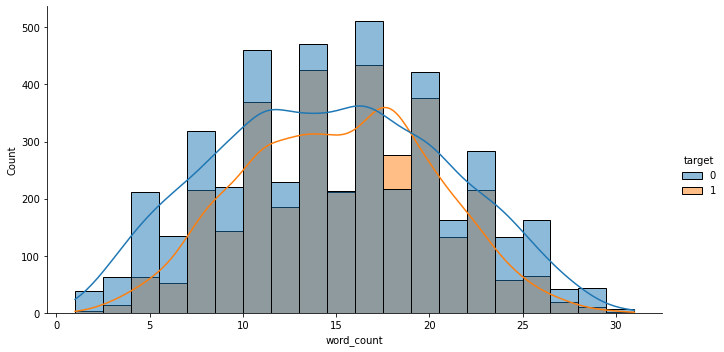

In [37]:
plt.figure(figsize = (8, 10))
sns.displot(data=train,
            kind='hist', 
            x='word_count', 
            hue='target', 
            kde=True,
            bins=20,
            height=5, 
            aspect=1.9)

## Step 2: Modeling

Keeping track of all performances:

|Model|Text-Preprocessing|Accuracy|Precision|Recall|F1|AUC|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|Dummy|N/A|57.38%|0.00%|0.00%|0.00%|50.00%|
|Logistic Regression|No Preprocessing|79.58%|78.84%|71.19%|74.82%|78.50%|
|Logistic Regression|Preprocessing|78.99%|79.64%|68.10%|73.42%|77.59%|
|SVC|No Preprocessing|77.41%|89.41%|53.31%|66.80%|74.31%|
|SVC|Preprocessing|77.74%|88.37%|55.00%|67.81%|74.81%|
|Random Forest|No Preprocessing|65.20%|97.60%|18.79%|31.52%|59.22%|
|Random Forest|Preprocessing|64.28%|99.07%|16.33%|28.04%|58.11%|
|BERT-Base (e=2, alternate b)|No Preprocessing|84.63%|87.25%|74.88%|80.60%|83.38%|
|BERT-Base (e=1, b=32)|No Preprocessing|82.73%|82.06%|76.11%|78.98%|81.88%|
|BERT-Base (e=2, b=64)|No Preprocessing|82.14%|78.26%|80.43%|79.33%|81.92%|
|DistillBERT-Base (e=2, b=16)|No Preprocessing|84.18%|84.69%|76.73%|80.52%|83.22%|
|DistillBERT-Base (e=1, b=32)|No Preprocessing|82.47%|82.93%|74.11%|78.28%|81.39%|
|DistillBERT-Base (e=5, b=64)|No Preprocessing|82.07%|82.19%|73.96%|77.88%|81.03%|
|RoBERTa-Base (e=2, b=16)|No Preprocessing|83.32%|80.91%|79.66%|80.28%|82.85%|
|RoBERTa-Base (e=2, b=32)|No Preprocessing|82.53%|81.14%|76.88%|78.96%|81.81%|
|RoBERTa-Base (e=1, b=64)|No Preprocessing|81.88%|79.00%|78.27%|78.64%|81.41%|
|RoBERTa-Base (e=2, alternate b)|No Preprocessing|82.40%|78.91%|80.12%|79.51%|82.11%|
|XLM-RoBERTa-Base (e=2, b=16)|No Preprocessing|82.14%|80.95%|75.96%|78.38%|81.34%|
|XLM-RoBERTa-Base (e=2, b=32)|No Preprocessing|82.14%|82.11%|74.27%|77.99%|81.13%|
|XLM-RoBERTa-Base (e=1, b=64)|No Preprocessing|81.88%|79.00%|78.27%|78.38%|81.41%|
|XLM-RoBERTa-Base (e=5, alternate b)|No Preprocessing|81.35%|78.03%|78.27%|78.15%|80.96%|

-----------------

## 2.1. Baselines

#### Baseline 1 - Dummy Classifier

A dummy baseline achieves an accuracy of **57.39%** and F1-Score of **0.00%**.

There should be no difference in the performance of dummy baseline for processed and non-processed texts.

In [43]:
def tfidf(data):
    """
    Function creates a tfidf tokenized training set and associated vectorizer for test data.

    Args:
        data (list): Training data to be tokenized.

    Returns:
        list: The edited training data.
        tfidf_vectorizer: tfidf vectorizer to be applied to test data.
    """
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

def compute_metrics_baseline(labels, preds):    
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall, "auc": auc}

train_tfidf, tfidf_vectorizer = tfidf(train_texts)
val_tfidf = tfidf_vectorizer.transform(val_texts)

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_tfidf, train_labels)

val_preds = dummy_clf.predict(val_tfidf)

compute_metrics_baseline(val_labels, val_preds)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.5738673670387393,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'auc': 0.5}

#### Baseline 2 - Logistic Regression

A logistic regression baseline (with TF-IDF transformation) achieves an accuracy of **79.58%** and F1-Score of **74.82%**. This is quite significant.

Fitting into the common theme, text processing actually **decreases** performance of the Logistic regression baseline.

In [44]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression(random_state=0).fit(train_tfidf, train_labels)
val_preds = logreg_clf.predict(val_tfidf)

compute_metrics_baseline(val_labels, val_preds)

{'accuracy': 0.7957977675640184,
 'f1': 0.748178137651822,
 'precision': 0.78839590443686,
 'recall': 0.711864406779661,
 'auc': 0.7849939882868557}

In [45]:
train_tfidf_prc, tfidf_vectorizer = tfidf(train_texts_processed)
val_tfidf_prc = tfidf_vectorizer.transform(val_texts_processed)

logreg_clf_prc = LogisticRegression(random_state=0).fit(train_tfidf_prc, train_labels)
val_preds_prc = logreg_clf_prc.predict(val_tfidf_prc)

compute_metrics_baseline(val_labels, val_preds_prc)

{'accuracy': 0.7898883782009193,
 'f1': 0.7342192691029902,
 'precision': 0.7963963963963964,
 'recall': 0.6810477657935285,
 'auc': 0.7758785739722791}

#### Baseline 3 - SVC

A SVC baseline (with TF-IDF transformation) achieves an accuracy of **77.41%** and F1-Score of **66.80%**. This is quite significant.

Text Processing doesn't seem to matter in the case of SVC. Text processing achieves very little improvements in metrics.

In [46]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svc_clf = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto')).fit(train_tfidf, train_labels)
val_preds = svc_clf.predict(val_tfidf)

compute_metrics_baseline(val_labels, val_preds)

{'accuracy': 0.7741300065659882,
 'f1': 0.667953667953668,
 'precision': 0.8940568475452196,
 'recall': 0.5331278890600925,
 'auc': 0.7431085669556755}

In [47]:
svc_clf = make_pipeline(StandardScaler(with_mean=False), 
                        SVC(gamma='auto')).fit(train_tfidf_prc, train_labels)
val_preds_prc = svc_clf.predict(val_tfidf_prc)

compute_metrics_baseline(val_labels, val_preds_prc)

{'accuracy': 0.7774130006565988,
 'f1': 0.6780626780626781,
 'precision': 0.8836633663366337,
 'recall': 0.5500770416024653,
 'auc': 0.7481506489476858}

#### Baseline 4 - Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=10, 
                                min_samples_split=3,
                                random_state=42)
rf_clf.fit(train_tfidf, train_labels)

val_preds = rf_clf.predict(val_tfidf)

compute_metrics_baseline(val_labels, val_preds)

{'accuracy': 0.6520026263952725,
 'f1': 0.31524547803617575,
 'precision': 0.976,
 'recall': 0.18798151001540833,
 'auc': 0.5922745078681161}

In [52]:
rf_clf = RandomForestClassifier(max_depth=10, 
                                min_samples_split=3,
                                random_state=42)
rf_clf.fit(train_tfidf_prc, train_labels)

val_preds_prc = rf_clf.predict(val_tfidf_prc)

compute_metrics_baseline(val_labels, val_preds_prc)

{'accuracy': 0.6428102429415627,
 'f1': 0.2804232804232804,
 'precision': 0.9906542056074766,
 'recall': 0.1633281972265023,
 'auc': 0.5810920162333885}

-----------------

## 2.2. Apply the Transformers models without any preprocessing to see if pre-processing add any benefits

#### First, I prepare the dataset for Transformers

In [54]:
train_df = pd.DataFrame(list(zip(train_texts, train_labels)),
                        columns =['text', 'label'])

val_df = pd.DataFrame(list(zip(val_texts, val_labels)),
                      columns =['text', 'label'])

In [59]:
data_path = '/kaggle/working/data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

train_df.to_csv(os.path.join(data_path, 'train_df.csv'), index=False)
val_df.to_csv(os.path.join(data_path, 'val_df.csv'), index=False)

tweets_dataset = load_dataset('csv', data_files={'train': os.path.join(data_path, 'train_df.csv'),
                                                 'validation': os.path.join(data_path, 'val_df.csv')})

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fffba8e3d1829887/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


In [60]:
tweets_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6090
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1523
    })
})

In [82]:
train_prc_df = pd.DataFrame(list(zip(train_texts_processed, train_labels)),
                            columns =['text', 'label'])

val_prc_df = pd.DataFrame(list(zip(val_texts_processed, val_labels)),
                          columns =['text', 'label'])

train_prc_df.to_csv(os.path.join(data_path, 'train_prc_df.csv'), index=False)
val_prc_df.to_csv(os.path.join(data_path, 'val_prc_df.csv'), index=False)

tweets_dataset_prc = load_dataset('csv', data_files={'train': os.path.join(data_path, 
                                                                           'train_prc_df.csv'),
                                                     'validation': os.path.join(data_path, 
                                                                                'val_prc_df.csv')})

In [85]:
tweets_dataset_prc

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6090
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1523
    })
})

#### Model 1 - BERT-Base

In [63]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'bert-base-uncased'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)
tweets_encoded = tweets_dataset.map(tokenize, batched=True, batch_size=None)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [64]:
set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=5,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.384100,0.416669,0.827315,0.800304,0.788922,0.812018,0.825346,3.084300,493.791000
2,0.316600,0.387641,0.846356,0.805970,0.872531,0.748844,0.833804,3.087000,493.357000
3,0.295600,0.572545,0.816809,0.790383,0.771261,0.810478,0.815994,3.078700,494.688000
4,0.203400,0.747886,0.803020,0.780059,0.744056,0.819723,0.805170,3.083900,493.850000
5,0.136900,0.876141,0.825345,0.793157,0.800628,0.785824,0.820258,3.080200,494.452000


TrainOutput(global_step=1905, training_loss=0.26997736913794923, metrics={'train_runtime': 410.5993, 'train_samples_per_second': 4.64, 'total_flos': 1680225644210400.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 9678011, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 569258, 'train_mem_gpu_alloc_delta': 1340402176, 'train_mem_cpu_peaked_delta': 188968650, 'train_mem_gpu_peaked_delta': 1086459392})

In [66]:
set_cuda_seed()

training_args.per_device_train_batch_size = 64

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.069200,0.907389,0.814839,0.790801,0.762518,0.821263,0.815666,3.079100,494.628000
2,0.058300,0.904109,0.821405,0.793313,0.782609,0.804314,0.819205,3.077600,494.870000
3,0.058200,0.863281,0.809586,0.780635,0.766716,0.795069,0.807718,3.085100,493.664000
4,0.046700,1.138878,0.803677,0.780309,0.745787,0.818182,0.805544,3.081800,494.195000
5,0.048000,1.426673,0.774787,0.764907,0.688889,0.859784,0.785727,3.081400,494.257000


TrainOutput(global_step=480, training_loss=0.05579450475051999, metrics={'train_runtime': 278.9427, 'train_samples_per_second': 1.721, 'total_flos': 1680225644210400.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 58813, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 237428, 'train_mem_gpu_alloc_delta': 885629952, 'train_mem_cpu_peaked_delta': 795662, 'train_mem_gpu_peaked_delta': 4271417344})

In [67]:
set_cuda_seed()

training_args.per_device_train_batch_size = 32

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.051600,1.036262,0.827315,0.789768,0.820598,0.761171,0.818801,3.079200,494.606000
2,0.040700,0.972484,0.825345,0.796636,0.790592,0.802773,0.822439,3.081800,494.190000
3,0.091900,0.760502,0.814839,0.780031,0.789889,0.770416,0.809121,3.085900,493.534000
4,0.042900,1.174758,0.810243,0.778883,0.773556,0.784284,0.806901,3.082000,494.163000
5,0.052200,1.179735,0.812213,0.779661,0.779661,0.779661,0.808023,3.079900,494.491000


TrainOutput(global_step=955, training_loss=0.05172657657668229, metrics={'train_runtime': 338.1404, 'train_samples_per_second': 2.824, 'total_flos': 1680225644210400.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 59357, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 246839, 'train_mem_gpu_alloc_delta': 905028608, 'train_mem_cpu_peaked_delta': 188510082, 'train_mem_gpu_peaked_delta': 2135981056})

#### Model 2 - DistillBERT

In [68]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = 'distilbert-base-uncased'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)
tweets_encoded = tweets_dataset.map(tokenize, batched=True, batch_size=None)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [69]:
set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=5,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.380700,0.507931,0.803020,0.784483,0.734859,0.841294,0.807947,1.556300,978.595000
2,0.278200,0.395182,0.841760,0.805174,0.846939,0.767334,0.832180,1.557800,977.674000
3,0.340800,0.574364,0.827971,0.798462,0.797235,0.799692,0.824331,1.568400,971.063000
4,0.185700,0.712767,0.804334,0.774584,0.760773,0.788906,0.802348,1.562800,974.510000
5,0.103700,0.791628,0.818122,0.784771,0.791536,0.778120,0.812973,1.556600,978.446000


TrainOutput(global_step=1905, training_loss=0.2651575835749233, metrics={'train_runtime': 213.6676, 'train_samples_per_second': 8.916, 'total_flos': 1027545147468000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 59742, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 841108, 'train_mem_gpu_alloc_delta': 820108800, 'train_mem_cpu_peaked_delta': 187914190, 'train_mem_gpu_peaked_delta': 551442432})

In [70]:
# DISTILLBERT, batch size = 32

set_cuda_seed()

training_args.per_device_train_batch_size = 32
training_args.per_device_eval_batch_size = 32

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.093400,0.819487,0.824688,0.782750,0.829310,0.741140,0.813934,1.625900,936.730000
2,0.073000,0.944394,0.806303,0.779357,0.757267,0.802773,0.805849,1.617900,941.352000
3,0.079400,0.972720,0.798424,0.777052,0.734890,0.824345,0.801761,1.618800,940.800000
4,0.030600,1.099330,0.808930,0.780045,0.765579,0.795069,0.807146,1.616800,941.976000
5,0.023400,1.159797,0.813526,0.782875,0.776935,0.788906,0.810357,1.617100,941.808000


TrainOutput(global_step=955, training_loss=0.05833371663904939, metrics={'train_runtime': 176.7441, 'train_samples_per_second': 5.403, 'total_flos': 1027545147468000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 60421, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 205769, 'train_mem_gpu_alloc_delta': 550897664, 'train_mem_cpu_peaked_delta': 188262246, 'train_mem_gpu_peaked_delta': 1086212096})

In [71]:
# DISTILLBERT, batch size = 64

set_cuda_seed()

batch_size = 64
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.024300,1.202012,0.816809,0.783888,0.788162,0.779661,0.812027,1.559900,976.315000
2,0.029400,1.220691,0.806960,0.776256,0.766917,0.785824,0.804239,1.554000,980.074000
3,0.031700,1.259334,0.799737,0.769114,0.755952,0.782743,0.797550,1.564000,973.777000
4,0.038800,1.246407,0.774787,0.754122,0.705094,0.810478,0.779381,1.555400,979.175000
5,0.046700,1.113085,0.820749,0.778589,0.821918,0.739599,0.810303,1.554500,979.721000


TrainOutput(global_step=480, training_loss=0.026399738714098932, metrics={'train_runtime': 143.8992, 'train_samples_per_second': 3.336, 'total_flos': 1027545147468000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 59309, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 179917, 'train_mem_gpu_alloc_delta': 541198336, 'train_mem_cpu_peaked_delta': 675035, 'train_mem_gpu_peaked_delta': 2166563840})

#### Model 3 - RoBERTa

In [72]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = 'roberta-base'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)
tweets_encoded = tweets_dataset.map(tokenize, batched=True, batch_size=None)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [73]:
set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=5,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.374900,0.477525,0.806960,0.780269,0.757620,0.804314,0.806619,3.976400,383.010000
2,0.346100,0.425982,0.833224,0.802795,0.809077,0.796610,0.828511,3.962100,384.391000
3,0.357500,0.600532,0.828628,0.795294,0.809904,0.781202,0.822523,3.971400,383.495000
4,0.411600,0.547375,0.822718,0.794521,0.784962,0.804314,0.820349,3.988800,381.815000
5,0.301500,0.701739,0.828628,0.794973,0.810897,0.779661,0.822325,3.977700,382.883000


TrainOutput(global_step=1905, training_loss=0.33196449965003905, metrics={'train_runtime': 416.9695, 'train_samples_per_second': 4.569, 'total_flos': 1935708226515000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 58302, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 298501, 'train_mem_gpu_alloc_delta': 1523687936, 'train_mem_cpu_peaked_delta': 310228715, 'train_mem_gpu_peaked_delta': 1086190592})

In [74]:
# ROBERTA, batch size = 32

set_cuda_seed()

batch_size = 32
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.091800,0.731773,0.823375,0.790987,0.797806,0.784284,0.818343,4.178300,364.501000
2,0.167800,0.631275,0.825345,0.789557,0.811382,0.768875,0.818076,4.180300,364.331000
3,0.208900,0.623328,0.813526,0.779160,0.786499,0.771957,0.808175,4.179100,364.432000
4,0.160700,0.874345,0.797768,0.772189,0.742532,0.804314,0.798610,4.175200,364.773000
5,0.124100,0.914742,0.823375,0.788688,0.804487,0.773498,0.816955,4.173800,364.894000


TrainOutput(global_step=955, training_loss=0.13189124440023411, metrics={'train_runtime': 351.4267, 'train_samples_per_second': 2.717, 'total_flos': 1935708226515000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 58517, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 254973, 'train_mem_gpu_alloc_delta': 1031469056, 'train_mem_cpu_peaked_delta': 309836290, 'train_mem_gpu_peaked_delta': 2154615808})

In [75]:
# ROBERTA, batch size = 64

set_cuda_seed()

batch_size = 64
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.078900,0.966888,0.818779,0.786378,0.790047,0.782743,0.814140,3.158000,482.273000
2,0.056000,1.251126,0.779383,0.766667,0.697851,0.850539,0.788542,3.162100,481.642000
3,0.054800,1.128682,0.786605,0.766691,0.717742,0.822804,0.791265,3.154700,482.772000
4,0.084900,0.891254,0.816809,0.784888,0.785494,0.784284,0.812622,3.168700,480.632000
5,0.070600,0.902372,0.810900,0.781487,0.769806,0.793529,0.808664,3.158400,482.210000


TrainOutput(global_step=480, training_loss=0.06769063311318556, metrics={'train_runtime': 282.6269, 'train_samples_per_second': 1.698, 'total_flos': 1935708226515000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 58429, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 234070, 'train_mem_gpu_alloc_delta': 1010759680, 'train_mem_cpu_peaked_delta': 725770, 'train_mem_gpu_peaked_delta': 4328633344})

In [76]:
# ROBERTA, train batch size = 16; eval batch size = 64

set_cuda_seed()

batch_size = 64
training_args.per_device_train_batch_size = 16
training_args.per_device_eval_batch_size = 64

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.106100,1.200747,0.797768,0.776488,0.733882,0.824345,0.801189,3.158500,482.194000
2,0.085000,0.998626,0.809586,0.772370,0.787200,0.758089,0.802958,3.155500,482.649000
3,0.099900,0.869788,0.824032,0.795107,0.789074,0.801233,0.821097,3.154100,482.861000
4,0.164100,0.977000,0.823375,0.788688,0.804487,0.773498,0.816955,3.159900,481.970000
5,0.091400,1.106576,0.816152,0.786585,0.778281,0.795069,0.813439,3.154700,482.771000


TrainOutput(global_step=1905, training_loss=0.08791634191433824, metrics={'train_runtime': 409.7328, 'train_samples_per_second': 4.649, 'total_flos': 1935708226515000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 58445, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 288997, 'train_mem_gpu_alloc_delta': 1010759680, 'train_mem_cpu_peaked_delta': 310165511, 'train_mem_gpu_peaked_delta': 1087050752})

#### Model 4 - XLM-RoBERTa

In [77]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = 'xlm-roberta-base'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)
tweets_encoded = tweets_dataset.map(tokenize, batched=True, batch_size=None)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [78]:
# XLM-ROBERTA, BATCH SIZE = 16

set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=5,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.454300,0.450621,0.816152,0.777070,0.803954,0.751926,0.807885,4.005200,380.252000
2,0.361100,0.439926,0.821405,0.783784,0.809524,0.759630,0.813454,4.010300,379.776000
3,0.421400,0.436134,0.814839,0.777953,0.795491,0.761171,0.807931,3.982500,382.423000
4,0.448100,0.521849,0.808273,0.779123,0.765230,0.793529,0.806375,3.985400,382.149000
5,0.288500,0.612607,0.811556,0.774194,0.790997,0.758089,0.804674,3.989600,381.739000


TrainOutput(global_step=1905, training_loss=0.4139234228084094, metrics={'train_runtime': 553.5878, 'train_samples_per_second': 3.441, 'total_flos': 5181483259184400.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 62050, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 285981, 'train_mem_gpu_alloc_delta': 3349812736, 'train_mem_cpu_peaked_delta': 1537414598, 'train_mem_gpu_peaked_delta': 1371959296})

In [79]:
# XLM-ROBERTA, batch size = 32

set_cuda_seed()

batch_size = 32
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.166500,0.583737,0.803020,0.771341,0.763198,0.779661,0.800014,4.185000,363.917000
2,0.252600,0.536577,0.821405,0.779935,0.821124,0.742681,0.811272,4.185100,363.907000
3,0.193100,0.528237,0.812213,0.767480,0.812392,0.727273,0.801279,4.188800,363.589000
4,0.245800,0.757559,0.776100,0.759011,0.701044,0.827427,0.782707,4.190100,363.477000
5,0.120500,0.841930,0.797768,0.765957,0.755622,0.776579,0.795040,4.189400,363.533000


TrainOutput(global_step=955, training_loss=0.19334270779375007, metrics={'train_runtime': 400.1556, 'train_samples_per_second': 2.387, 'total_flos': 5181483259184400.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 58277, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 253998, 'train_mem_gpu_alloc_delta': 2232875008, 'train_mem_cpu_peaked_delta': 1537022439, 'train_mem_gpu_peaked_delta': 2713649152})

In [80]:
# XLM-ROBERTA, batch size = 64

set_cuda_seed()

batch_size = 64
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.107700,0.821001,0.795141,0.765414,0.747430,0.784284,0.793744,3.641800,418.204000
2,0.075400,0.784763,0.793171,0.760820,0.750000,0.771957,0.790441,3.640100,418.397000
3,0.113900,0.868897,0.804334,0.773900,0.762332,0.785824,0.801951,3.646000,417.714000
4,0.139800,0.934015,0.782009,0.765867,0.706112,0.836672,0.789045,3.651900,417.046000
5,0.199600,0.854983,0.783979,0.757196,0.726629,0.790447,0.784812,3.651100,417.133000


TrainOutput(global_step=480, training_loss=0.10278550858298938, metrics={'train_runtime': 330.9366, 'train_samples_per_second': 1.45, 'total_flos': 5181483259184400.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 57357, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 236173, 'train_mem_gpu_alloc_delta': 2228408320, 'train_mem_cpu_peaked_delta': 746146, 'train_mem_gpu_peaked_delta': 5410927616})

In [81]:
# XLM-ROBERTA, Alternate batch size

set_cuda_seed()

training_args.per_device_train_batch_size = 16
training_args.per_device_eval_batch_size = 54

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.128200,1.249580,0.787262,0.768240,0.716956,0.827427,0.792432,3.457400,440.502000
2,0.112400,1.029430,0.776756,0.759547,0.701961,0.827427,0.783279,3.456900,440.565000
3,0.103200,0.930210,0.808273,0.780451,0.762115,0.799692,0.807169,3.459800,440.201000
4,0.125900,1.166522,0.795798,0.774474,0.731507,0.822804,0.799274,3.456700,440.588000
5,0.135400,1.131894,0.813526,0.781538,0.780338,0.782743,0.809564,3.457900,440.447000


TrainOutput(global_step=1905, training_loss=0.13170456683307183, metrics={'train_runtime': 567.7246, 'train_samples_per_second': 3.355, 'total_flos': 5181483259184400.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 57445, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 289613, 'train_mem_gpu_alloc_delta': 2228408320, 'train_mem_cpu_peaked_delta': 1537354099, 'train_mem_gpu_peaked_delta': 1374734336})

---------------------------

### 2.3. Apply Models with Preprocessed Data

We observe that the Models with Proprocessed Data perform generally worse than without preprocessing.

TO-DO: Log Performance Later

#### Model 1 - DistillBERT

In [86]:
model_name = 'distilbert-base-uncased'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)
tweets_encoded = tweets_dataset_prc.map(tokenize, batched=True, batch_size=None)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [87]:
# DISTILLBERT, BATCH SIZE = 16

set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=5,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.436300,0.448120,0.810243,0.774747,0.783912,0.765794,0.804521,1.478600,1030.054000
2,0.316500,0.448849,0.812213,0.774448,0.793215,0.756549,0.805048,1.480800,1028.490000
3,0.324300,0.548614,0.801051,0.767460,0.764526,0.770416,0.797107,1.477300,1030.922000
4,0.304100,0.852207,0.766251,0.744253,0.697174,0.798151,0.770357,1.492700,1020.308000
5,0.187500,0.936538,0.786605,0.755087,0.738938,0.771957,0.784720,1.476600,1031.411000


TrainOutput(global_step=1905, training_loss=0.3042660809564465, metrics={'train_runtime': 173.1884, 'train_samples_per_second': 11.0, 'total_flos': 636099377004000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 64899, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 240666, 'train_mem_gpu_alloc_delta': 819436032, 'train_mem_cpu_peaked_delta': 188545613, 'train_mem_gpu_peaked_delta': 315471360})

In [88]:
# DISTILLBERT, BATCH SIZE = 32

set_cuda_seed()

batch_size = 32
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.069300,0.905419,0.791202,0.759091,0.746647,0.771957,0.788724,1.276000,1193.615000
2,0.099000,0.892546,0.792515,0.762048,0.745214,0.779661,0.790860,1.272800,1196.601000
3,0.092900,1.032827,0.757715,0.733574,0.690217,0.782743,0.760937,1.275700,1193.891000
4,0.087100,1.182276,0.785292,0.753208,0.738166,0.768875,0.783179,1.285200,1185.072000
5,0.057100,1.242301,0.780696,0.752593,0.724679,0.782743,0.780959,1.273100,1196.322000


TrainOutput(global_step=955, training_loss=0.07443335387095107, metrics={'train_runtime': 121.2532, 'train_samples_per_second': 7.876, 'total_flos': 636099377004000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 59101, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 204291, 'train_mem_gpu_alloc_delta': 539094016, 'train_mem_cpu_peaked_delta': 188264287, 'train_mem_gpu_peaked_delta': 628525568})

In [89]:
# DISTILLBERT, BATCH SIZE = 64

set_cuda_seed()

batch_size = 64
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.041600,1.275790,0.782009,0.752608,0.728716,0.778120,0.781509,1.331600,1143.734000
2,0.038500,1.290219,0.779383,0.746988,0.730486,0.764253,0.777435,1.235300,1232.881000
3,0.041900,1.251553,0.773473,0.748725,0.709945,0.791988,0.775857,1.231300,1236.949000
4,0.042200,1.280395,0.780039,0.746788,0.732938,0.761171,0.777611,1.231500,1236.714000
5,0.060400,1.396290,0.764938,0.743920,0.694259,0.801233,0.769609,1.228400,1239.831000


TrainOutput(global_step=480, training_loss=0.03591794210175673, metrics={'train_runtime': 97.8277, 'train_samples_per_second': 4.907, 'total_flos': 636099377004000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 59445, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 186790, 'train_mem_gpu_alloc_delta': 539094016, 'train_mem_cpu_peaked_delta': 606472, 'train_mem_gpu_peaked_delta': 1241171456})

In [90]:
# DISTILLBERT, ALTERNATE BATCH SIZE

set_cuda_seed()

batch_size = 64
training_args.per_device_train_batch_size = 16
training_args.per_device_eval_batch_size = 64

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.045800,1.480103,0.730138,0.724346,0.641330,0.832049,0.743256,1.238500,1229.736000
2,0.058800,1.266279,0.789232,0.749805,0.758675,0.741140,0.783042,1.237700,1230.522000
3,0.017700,1.226236,0.793828,0.744300,0.789292,0.704160,0.782286,1.231300,1236.889000
4,0.091200,1.400789,0.785292,0.745525,0.753145,0.738059,0.779212,1.235800,1232.357000
5,0.036600,1.602843,0.774130,0.742515,0.721980,0.764253,0.772859,1.232900,1235.304000


TrainOutput(global_step=1905, training_loss=0.048202242672668275, metrics={'train_runtime': 169.1632, 'train_samples_per_second': 11.261, 'total_flos': 636099377004000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 58397, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 831562, 'train_mem_gpu_alloc_delta': 539094016, 'train_mem_cpu_peaked_delta': 188501782, 'train_mem_gpu_peaked_delta': 315471360})

#### Model 2 - BERT

In [91]:
model_name = 'bert-base-uncased'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)
tweets_encoded = tweets_dataset_prc.map(tokenize, batched=True, batch_size=None)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [92]:
# BERT, BATCH SIZE = 16

set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=5,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.433000,0.493087,0.793828,0.769457,0.734923,0.807396,0.795574,2.947800,516.656000
2,0.354800,0.452807,0.820092,0.779032,0.817259,0.744222,0.810326,2.951000,516.091000
3,0.363400,0.483221,0.805647,0.765079,0.788871,0.742681,0.797542,2.938300,518.325000
4,0.297600,0.628000,0.798424,0.766540,0.756757,0.776579,0.795612,2.906900,523.930000
5,0.179300,0.859537,0.804334,0.767551,0.777251,0.758089,0.798381,2.950600,516.164000


TrainOutput(global_step=1905, training_loss=0.33023957664885234, metrics={'train_runtime': 327.3885, 'train_samples_per_second': 5.819, 'total_flos': 1040139684511200.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 64675, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 286788, 'train_mem_gpu_alloc_delta': 1337938944, 'train_mem_cpu_peaked_delta': 189042154, 'train_mem_gpu_peaked_delta': 622353408})

In [ ]:
# BERT, BATCH SIZE = 32

set_cuda_seed()

batch_size = 32
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

In [93]:
# BERT, BATCH SIZE = 64

set_cuda_seed()

batch_size = 64
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.116100,0.804013,0.793171,0.760820,0.750000,0.771957,0.790441,2.457400,619.772000
2,0.092900,0.847194,0.794485,0.761615,0.753012,0.770416,0.791387,2.448300,622.072000
3,0.081700,0.975983,0.764281,0.745209,0.690789,0.808937,0.770029,2.445900,622.666000
4,0.079400,0.917360,0.787262,0.753799,0.743628,0.764253,0.784300,2.446000,622.645000
5,0.125900,1.022981,0.783322,0.760174,0.719395,0.805855,0.786223,2.440500,624.041000


TrainOutput(global_step=480, training_loss=0.08004579488188028, metrics={'train_runtime': 188.8364, 'train_samples_per_second': 2.542, 'total_flos': 1040139684511200.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 60173, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 236476, 'train_mem_gpu_alloc_delta': 879156736, 'train_mem_cpu_peaked_delta': 720571, 'train_mem_gpu_peaked_delta': 2460931584})

In [94]:
# BERT, ALTERNATE BATCH SIZE

set_cuda_seed()

batch_size = 64
training_args.per_device_train_batch_size = 16
training_args.per_device_eval_batch_size = 64

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.078600,1.305586,0.741300,0.730874,0.656442,0.824345,0.751990,2.443400,623.299000
2,0.158600,0.845192,0.800394,0.749175,0.806394,0.699538,0.787412,2.434900,625.499000
3,0.029900,1.164245,0.790545,0.757045,0.748494,0.765794,0.787359,2.448800,621.927000
4,0.097400,1.418789,0.774787,0.747237,0.716102,0.781202,0.775612,2.448500,622.009000
5,0.033500,1.449569,0.787919,0.753998,0.745482,0.762712,0.784674,2.440300,624.101000


TrainOutput(global_step=1905, training_loss=0.07174895955762994, metrics={'train_runtime': 318.747, 'train_samples_per_second': 5.977, 'total_flos': 1040139684511200.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 59429, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 287324, 'train_mem_gpu_alloc_delta': 880723456, 'train_mem_cpu_peaked_delta': 188964243, 'train_mem_gpu_peaked_delta': 622353408})

#### Model 3 - RoBERTa

In [95]:
model_name = 'roberta-base'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)
tweets_encoded = tweets_dataset_prc.map(tokenize, batched=True, batch_size=None)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [96]:
# ROBERTA, BATCH SIZE = 16

set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=5,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.478200,0.653095,0.744583,0.742895,0.650463,0.865948,0.760205,2.583700,589.461000
2,0.463400,0.536218,0.764938,0.638384,0.926686,0.486903,0.729149,2.509700,606.836000
3,0.453600,0.457539,0.812213,0.774448,0.793215,0.756549,0.805048,2.501100,608.939000
4,0.513900,0.497330,0.803677,0.766224,0.777778,0.755008,0.797412,2.629900,579.113000
5,0.379800,0.488366,0.815496,0.779608,0.793930,0.765794,0.809098,2.595400,586.798000


TrainOutput(global_step=1905, training_loss=0.4680079192314248, metrics={'train_runtime': 282.5954, 'train_samples_per_second': 6.741, 'total_flos': 1047559746114000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 59470, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 282932, 'train_mem_gpu_alloc_delta': 1502477824, 'train_mem_cpu_peaked_delta': 310236475, 'train_mem_gpu_peaked_delta': 562674688})

In [97]:
# ROBERTA, BATCH SIZE = 32

set_cuda_seed()

batch_size = 32
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.293100,0.476329,0.824688,0.784851,0.822635,0.750385,0.815124,2.044400,744.973000
2,0.333700,0.488231,0.820749,0.780723,0.815436,0.748844,0.811493,2.040700,746.320000
3,0.308300,0.572875,0.789232,0.758101,0.741888,0.775039,0.787405,2.057800,740.097000
4,0.372300,0.706005,0.750492,0.741497,0.663825,0.839753,0.761982,2.041100,746.153000
5,0.268200,0.555090,0.799081,0.769925,0.751836,0.788906,0.797771,2.040300,746.467000


TrainOutput(global_step=955, training_loss=0.32719765533327433, metrics={'train_runtime': 214.3332, 'train_samples_per_second': 4.456, 'total_flos': 1047559746114000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 58933, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 251733, 'train_mem_gpu_alloc_delta': 999118848, 'train_mem_cpu_peaked_delta': 309836043, 'train_mem_gpu_peaked_delta': 1090786304})

In [98]:
# ROBERTA, BATCH SIZE = 64

set_cuda_seed()

batch_size = 64
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.262100,0.554233,0.796454,0.771386,0.739745,0.805855,0.797664,2.141800,711.086000
2,0.227700,0.580534,0.808930,0.771046,0.787781,0.755008,0.801989,2.143800,710.405000
3,0.220000,0.618453,0.803677,0.775019,0.757353,0.793529,0.802371,2.155000,706.744000
4,0.198000,0.606731,0.806960,0.770312,0.781300,0.759630,0.800868,2.148300,708.934000
5,0.332100,0.688988,0.765594,0.746988,0.691601,0.812018,0.771570,2.139900,711.709000


TrainOutput(global_step=480, training_loss=0.22710321297248204, metrics={'train_runtime': 174.2404, 'train_samples_per_second': 2.755, 'total_flos': 1047559746114000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 59069, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 236061, 'train_mem_gpu_alloc_delta': 999118848, 'train_mem_cpu_peaked_delta': 663370, 'train_mem_gpu_peaked_delta': 2127685632})

In [99]:
# ROBERTA, ALTERNATE BATCH SIZE

set_cuda_seed()

batch_size = 32
training_args.per_device_train_batch_size = 16
training_args.per_device_eval_batch_size = 64

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.233800,0.943503,0.735391,0.735043,0.641055,0.861325,0.751601,2.143300,710.589000
2,0.149000,0.841780,0.778726,0.751658,0.720339,0.785824,0.779640,2.140600,711.491000
3,0.139900,0.657773,0.782666,0.757509,0.722067,0.796610,0.784461,2.142700,710.799000
4,0.243600,0.850542,0.753775,0.733096,0.681217,0.793529,0.758892,2.149400,708.580000
5,0.261900,0.808784,0.782009,0.749245,0.734815,0.764253,0.779724,2.141700,711.129000


TrainOutput(global_step=1905, training_loss=0.20245603380866564, metrics={'train_runtime': 276.5422, 'train_samples_per_second': 6.889, 'total_flos': 1047559746114000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 58701, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 288437, 'train_mem_gpu_alloc_delta': 999379968, 'train_mem_cpu_peaked_delta': 310165287, 'train_mem_gpu_peaked_delta': 562674688})

#### Model 4 - XLM-RoBERTa

In [100]:
model_name = 'xlm-roberta-base'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)
tweets_encoded = tweets_dataset_prc.map(tokenize, batched=True, batch_size=None)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [101]:
# XLM-ROBERTA, BATCH SIZE = 16

set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=5,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.551100,0.533284,0.776100,0.695807,0.826271,0.600924,0.753551,2.847900,534.775000
2,0.598400,0.550574,0.751806,0.673010,0.767258,0.599384,0.732186,2.856800,533.111000
3,0.603400,0.562373,0.789232,0.730025,0.803704,0.668721,0.773720,2.849800,534.433000
4,0.542500,0.501632,0.793171,0.754482,0.763407,0.745763,0.787069,2.922000,521.227000
5,0.479600,0.497789,0.795798,0.749799,0.784512,0.718028,0.785787,2.845900,535.154000


TrainOutput(global_step=1905, training_loss=0.5438121632953954, metrics={'train_runtime': 395.9671, 'train_samples_per_second': 4.811, 'total_flos': 2489143918627800.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 63931, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 286929, 'train_mem_gpu_alloc_delta': 3342390784, 'train_mem_cpu_peaked_delta': 1537412835, 'train_mem_gpu_peaked_delta': 771453440})

In [102]:
# XLM-ROBERTA, BATCH SIZE = 32

set_cuda_seed()

batch_size = 32
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.405100,0.467429,0.791858,0.725065,0.829365,0.644068,0.772835,2.423100,628.540000
2,0.392600,0.489939,0.797768,0.745455,0.803922,0.694915,0.784529,2.410800,631.748000
3,0.531300,0.590386,0.783979,0.746728,0.746154,0.747304,0.779258,2.409300,632.126000
4,0.478100,0.514511,0.785292,0.745129,0.753943,0.736518,0.779014,2.412400,631.309000
5,0.398300,0.509533,0.781353,0.738824,0.752396,0.725732,0.774193,2.412000,631.424000


TrainOutput(global_step=955, training_loss=0.4450613478715507, metrics={'train_runtime': 264.728, 'train_samples_per_second': 3.607, 'total_flos': 2489143918627800.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 58669, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 252742, 'train_mem_gpu_alloc_delta': 2225297408, 'train_mem_cpu_peaked_delta': 1537023863, 'train_mem_gpu_peaked_delta': 1149223424})

In [103]:
# XLM-ROBERTA, BATCH SIZE = 64

set_cuda_seed()

batch_size = 64
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.386700,0.515022,0.787919,0.748638,0.756289,0.741140,0.781897,2.303300,661.219000
2,0.385000,0.496408,0.795798,0.753370,0.776144,0.731895,0.787572,2.303200,661.257000
3,0.403400,0.494306,0.799737,0.759274,0.778317,0.741140,0.792195,2.312700,658.534000
4,0.404300,0.623651,0.774130,0.754986,0.701987,0.816641,0.779602,2.304300,660.950000
5,0.422800,0.488627,0.791202,0.750784,0.763955,0.738059,0.784361,2.304800,660.792000


TrainOutput(global_step=480, training_loss=0.38764378676811856, metrics={'train_runtime': 188.2988, 'train_samples_per_second': 2.549, 'total_flos': 2489143918627800.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 59301, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 236446, 'train_mem_gpu_alloc_delta': 2225297408, 'train_mem_cpu_peaked_delta': 673214, 'train_mem_gpu_peaked_delta': 2267061248})

In [104]:
# XLM-ROBERTA, ALTERNATE BATCH SIZE

set_cuda_seed()

batch_size = 32
training_args.per_device_train_batch_size = 16
training_args.per_device_eval_batch_size = 64

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.349400,0.531931,0.784636,0.741325,0.759289,0.724191,0.776855,2.300700,661.972000
2,0.580200,0.602119,0.692055,0.462772,0.901786,0.311248,0.643038,2.302200,661.546000
3,0.378000,0.543283,0.789888,0.733333,0.798548,0.677966,0.775482,2.301900,661.632000
4,0.558700,0.558497,0.784636,0.712785,0.825558,0.627119,0.764360,2.306800,660.214000
5,0.338600,0.560158,0.798424,0.747740,0.801056,0.701079,0.785894,2.302700,661.393000


TrainOutput(global_step=1905, training_loss=0.3868970046206096, metrics={'train_runtime': 414.6066, 'train_samples_per_second': 4.595, 'total_flos': 2489143918627800.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 59069, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 879873, 'train_mem_gpu_alloc_delta': 2225297408, 'train_mem_cpu_peaked_delta': 1537350011, 'train_mem_gpu_peaked_delta': 771453440})

-------------------

## 2.4. Hyperparameters Tuning

In this section, I will focus solely on BERT-Base, no text preprocessing because it achieves the best accuracy so far.

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'bert-base-uncased'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)
tweets_encoded = tweets_dataset.map(tokenize, batched=True, batch_size=None)

model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [110]:
tweets_encoded

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 6090
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 1523
    })
})

In [107]:
set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=5,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.398300,0.461868,0.804990,0.781457,0.747887,0.818182,0.806688,3.401700,447.721000
2,0.320000,0.395346,0.843729,0.803306,0.866310,0.748844,0.831516,3.400500,447.870000
3,0.335500,0.545667,0.822718,0.794207,0.785822,0.802773,0.820151,3.440300,442.693000
4,0.206400,0.802079,0.809586,0.783259,0.760522,0.807396,0.809304,3.397800,448.230000
5,0.157100,0.850523,0.821405,0.787500,0.798732,0.776579,0.815635,3.397000,448.343000


TrainOutput(global_step=1905, training_loss=0.27335793571131123, metrics={'train_runtime': 411.0058, 'train_samples_per_second': 4.635, 'total_flos': 1680225644210400.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 65011, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 287772, 'train_mem_gpu_alloc_delta': 1322197504, 'train_mem_cpu_peaked_delta': 189040583, 'train_mem_gpu_peaked_delta': 1082978816})

In [113]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels)

In [116]:
tweets_encoded.set_format("torch",
                          columns=["input_ids", "attention_mask", "label"])

set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=5,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=tweets_encoded["train"],
    eval_dataset=tweets_encoded["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.398300,0.461868,0.804990,0.781457,0.747887,0.818182,0.806688,4.885500,311.739000
2,0.320000,0.395346,0.843729,0.803306,0.866310,0.748844,0.831516,4.453100,342.006000
3,0.335500,0.545667,0.822718,0.794207,0.785822,0.802773,0.820151,4.416500,344.845000
4,0.206400,0.802079,0.809586,0.783259,0.760522,0.807396,0.809304,4.609500,330.407000
5,0.157100,0.850523,0.821405,0.787500,0.798732,0.776579,0.815635,4.745300,320.946000


TrainOutput(global_step=1905, training_loss=0.27335793571131123, metrics={'train_runtime': 459.9487, 'train_samples_per_second': 4.142, 'total_flos': 1680225644210400.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 104562, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 202307, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 295377, 'train_mem_gpu_alloc_delta': 1321312768, 'train_mem_cpu_peaked_delta': 189038877, 'train_mem_gpu_peaked_delta': 1083695616})

In [117]:
!pip install optuna

In [120]:
train_subset = tweets_encoded["train"].shard(index=1, num_shards=5)
eval_subset = tweets_encoded["validation"].shard(index=1, num_shards=5)

In [128]:
set_cuda_seed()

training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=3,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,               
    logging_dir='./logs',       
    logging_steps=10,
)

trainer = Trainer(model_init=model_init, 
                  args=training_args,
                  compute_metrics=compute_metrics, 
                  train_dataset=train_subset,
                  eval_dataset=eval_subset)

best_run = trainer.hyperparameter_search(n_trials=5, 
                                         direction="maximize")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.677500,0.663980,0.596721,0.655462,0.520000,0.886364,0.631043,0.938500,324.984000
2,0.590500,0.582148,0.718033,0.699301,0.649351,0.757576,0.722719,0.955300,319.258000


[I 2021-04-04 22:17:14,005] Trial 0 finished with value: 3.546978407738381 and parameters: {'learning_rate': 1.9794712643338832e-06, 'num_train_epochs': 2, 'seed': 1, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 3.546978407738381.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the check

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.682500,0.651523,0.583607,0.646240,0.511013,0.878788,0.618585,1.103800,276.311000
2,0.603900,0.529530,0.750820,0.693548,0.741379,0.651515,0.739052,0.957200,318.649000
3,0.462700,0.499233,0.773770,0.756184,0.708609,0.810606,0.778135,0.966100,315.696000


[I 2021-04-04 22:18:28,643] Trial 1 finished with value: 3.8273049697607835 and parameters: {'learning_rate': 3.703407111165308e-06, 'num_train_epochs': 3, 'seed': 30, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 3.8273049697607835.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the che

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.783200,0.765010,0.563934,0.000000,0.000000,0.000000,0.497110,0.942500,323.623000
2,0.706300,0.752150,0.563934,0.000000,0.000000,0.000000,0.497110,0.952100,320.329000
3,0.741100,0.732333,0.563934,0.000000,0.000000,0.000000,0.497110,0.945100,322.719000
4,0.747200,0.701996,0.563934,0.000000,0.000000,0.000000,0.497110,0.941200,324.057000
5,0.681100,0.668886,0.563934,0.014815,0.333333,0.007576,0.498008,0.938300,325.042000


[I 2021-04-04 22:19:40,965] Trial 2 finished with value: 1.4176658639204835 and parameters: {'learning_rate': 3.353320795683662e-06, 'num_train_epochs': 5, 'seed': 2, 'per_device_train_batch_size': 64}. Best is trial 1 with value: 3.8273049697607835.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the che

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.430100,0.452045,0.813115,0.792727,0.762238,0.825758,0.814613,0.949100,321.369000
2,0.563500,0.676080,0.813115,0.801394,0.741935,0.871212,0.819999,0.949100,321.353000
3,0.585500,0.789173,0.822951,0.801471,0.778571,0.825758,0.823283,0.963500,316.554000
4,0.264400,0.833360,0.829508,0.805970,0.794118,0.818182,0.828166,0.954400,319.584000


[I 2021-04-04 22:22:06,784] Trial 3 finished with value: 4.075943864815264 and parameters: {'learning_rate': 3.0926228561475635e-05, 'num_train_epochs': 4, 'seed': 32, 'per_device_train_batch_size': 4}. Best is trial 3 with value: 4.075943864815264.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the chec

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.620000,0.554254,0.734426,0.729097,0.652695,0.825758,0.745249,0.949200,321.317000
2,0.591700,0.459070,0.800000,0.782918,0.738255,0.833333,0.803950,0.936400,325.713000


[I 2021-04-04 22:22:57,017] Trial 4 finished with value: 3.958456420017459 and parameters: {'learning_rate': 1.3514222297819783e-05, 'num_train_epochs': 2, 'seed': 3, 'per_device_train_batch_size': 8}. Best is trial 3 with value: 4.075943864815264.


In [129]:
best_run

BestRun(run_id='3', objective=4.075943864815264, hyperparameters={'learning_rate': 3.0926228561475635e-05, 'num_train_epochs': 4, 'seed': 32, 'per_device_train_batch_size': 4})

In [130]:
for key, value in best_run.hyperparameters.items():
    setattr(trainer.args, key, value)

trainer.train_dataset = tweets_encoded["train"]
trainer.eval_dataset = tweets_encoded["validation"]
trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.400800,0.468558,0.832567,0.790812,0.845614,0.742681,0.820997,4.881300,312.009000
2,0.454800,0.474542,0.843729,0.809295,0.843072,0.778120,0.835284,4.731100,321.911000
3,0.243600,0.806386,0.824688,0.797574,0.785075,0.810478,0.822859,4.878200,312.205000
4,0.002600,0.885972,0.834537,0.804651,0.809672,0.799692,0.830052,4.479600,339.987000


TrainOutput(global_step=6092, training_loss=0.41640878909020435, metrics={'train_runtime': 705.9342, 'train_samples_per_second': 8.63, 'total_flos': 1344180515368320.0, 'epoch': 4.0, 'train_mem_cpu_alloc_delta': 1138250, 'train_mem_gpu_alloc_delta': -522240, 'train_mem_cpu_peaked_delta': 189147493, 'train_mem_gpu_peaked_delta': 439266816})

In [145]:
results = trainer.evaluate()

In [147]:
results['eval_accuracy']

0.8207485226526592

------------------------

## 2.5. Choose a Final Model and Evaluate This Model on Multiple Train-Eval Split

In [150]:
# BestRun(run_id='3', 
# objective=4.075943864815264, 
# hyperparameters={'learning_rate': 3.0926228561475635e-05, 'num_train_epochs': 4, 
# 'seed': 32, 'per_device_train_batch_size': 4})

all_train_texts = train.text.to_list()
all_train_labels = train.target.to_list()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'bert-base-uncased'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

accs = []

for i in range(0, 5):
    
    seed = random.randint(0, 1000)

    train_texts_rand, val_texts_rand, train_labels_rand, val_labels_rand = train_test_split(
        all_train_texts, all_train_labels, 
        test_size=0.2, 
        random_state=seed
    )
    
    train_df_rand = pd.DataFrame(list(zip(train_texts_rand, train_labels_rand)),
                                 columns =['text', 'label'])

    val_df_rand = pd.DataFrame(list(zip(val_texts_rand, val_labels_rand)),
                               columns =['text', 'label'])

    train_df_rand.to_csv(os.path.join(data_path, 'train_df_rand.csv'), index=False)
    val_df_rand.to_csv(os.path.join(data_path, 'val_df_rand.csv'), index=False)

    tweets_dataset_rand = load_dataset('csv', data_files={'train': os.path.join(data_path, 
                                                                               'train_df_rand.csv'),
                                                          'validation': os.path.join(data_path, 
                                                                                    'val_df_rand.csv')})
    
    tweets_encoded_rand = tweets_dataset_rand.map(tokenize, batched=True, batch_size=None)

    set_cuda_seed()
    
    training_args = TrainingArguments(
        output_dir='./results',         
        num_train_epochs=2,             
        per_device_train_batch_size=16,  
        per_device_eval_batch_size=64,   
        warmup_steps=500,
        evaluation_strategy="epoch",
        weight_decay=0.01,               
        logging_dir='./logs',       
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,                      
        args=training_args,                 
        train_dataset=tweets_encoded_rand["train"],
        eval_dataset=tweets_encoded_rand["validation"],
        compute_metrics=compute_metrics
    )

    trainer.train()
    
    acc_rand = float(trainer.evaluate()['eval_accuracy'])
    accs.append(acc_rand)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-814707f59a0766b4/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.413600,0.468578,0.822718,0.806867,0.772603,0.844311,0.825080,3.676300,414.270000
2,0.388300,0.397790,0.837163,0.815750,0.809735,0.821856,0.835490,3.675400,414.373000


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-84c7d1ef6fd0621d/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.302000,0.262446,0.900197,0.873544,0.905172,0.844051,0.891504,3.142200,484.694000
2,0.254700,0.318142,0.892318,0.865794,0.881667,0.850482,0.885840,3.140900,484.896000


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-51a85ca0d7380bc0/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.125300,0.563911,0.883125,0.855049,0.866337,0.844051,0.877076,3.141100,484.864000
2,0.247900,0.529141,0.871963,0.846093,0.831008,0.861736,0.870380,3.141000,484.875000


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-9f73ad38e72f853c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.057500,0.856954,0.875246,0.833040,0.918605,0.762058,0.857722,3.140000,485.039000
2,0.196500,0.595805,0.854235,0.828173,0.798507,0.860129,0.855148,3.141600,484.784000


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1aeb2af55132318d/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.003300,1.014512,0.862771,0.832934,0.828299,0.837621,0.858877,3.140400,484.967000
2,0.228800,0.641181,0.850952,0.823071,0.798790,0.848875,0.850630,3.143600,484.482000


NameError: name 'mean' is not defined

In [154]:
avg_acc = np.mean(accs)
print(f'Average Accuracy is {avg_acc}')

Average Accuracy is 0.8613263296126068


In [ ]:
# BestRun(run_id='3', 
# objective=4.075943864815264, 
# hyperparameters={'learning_rate': 3.0926228561475635e-05, 'num_train_epochs': 4, 
# 'seed': 32, 'per_device_train_batch_size': 4})

all_train_texts = train.text.to_list()
all_train_labels = train.target.to_list()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'bert-base-uncased'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)

accs = []

for i in range(0, 5):
    
    seed = random.randint(0, 1000)

    train_texts_rand, val_texts_rand, train_labels_rand, val_labels_rand = train_test_split(
        all_train_texts, all_train_labels, 
        test_size=0.2, 
        random_state=seed
    )
    
    train_df_rand = pd.DataFrame(list(zip(train_texts_rand, train_labels_rand)),
                                 columns =['text', 'label'])

    val_df_rand = pd.DataFrame(list(zip(val_texts_rand, val_labels_rand)),
                               columns =['text', 'label'])

    train_df_rand.to_csv(os.path.join(data_path, 'train_df_rand.csv'), index=False)
    val_df_rand.to_csv(os.path.join(data_path, 'val_df_rand.csv'), index=False)

    tweets_dataset_rand = load_dataset('csv', data_files={'train': os.path.join(data_path, 
                                                                               'train_df_rand.csv'),
                                                          'validation': os.path.join(data_path, 
                                                                                    'val_df_rand.csv')})
    
    tweets_encoded_rand = tweets_dataset_rand.map(tokenize, batched=True, batch_size=None)

    model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))
    
    transformers.set_seed(42)
    
    training_args = TrainingArguments(
        output_dir='./results',         
        num_train_epochs=2,             
        per_device_train_batch_size=16,  
        per_device_eval_batch_size=64,   
        warmup_steps=500,
        evaluation_strategy="epoch",
        weight_decay=0.01,               
        logging_dir='./logs',       
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,                      
        args=training_args,                 
        train_dataset=tweets_encoded_rand["train"],
        eval_dataset=tweets_encoded_rand["validation"],
        compute_metrics=compute_metrics
    )

    trainer.train()
    
    acc_rand = float(trainer.evaluate()['eval_accuracy'])
    accs.append(acc_rand)

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-9a637b196696e477/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.416900,0.399743,0.835850,0.793729,0.815254,0.773312,0.826168,3.157800,482.295000
2,0.402700,0.416613,0.827971,0.794992,0.774390,0.816720,0.826229,3.141000,484.874000


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-07c20749a18048b5/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.453100,0.397562,0.829941,0.779199,0.829401,0.734727,0.815199,3.139900,485.050000
2,0.356700,0.414885,0.835850,0.802215,0.789720,0.815113,0.832640,3.140100,485.022000


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-452d86d612d7c014/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc,Runtime,Samples Per Second
1,0.453100,0.397562,0.829941,0.779199,0.829401,0.734727,0.815199,3.142100,484.713000


In [155]:
!rm -r /kaggle/working/results